In [233]:
# to enable autocomplete
%config Completer.use_jedi = False

**Reminder: TODO every time you want to  commit changes**

Go to `Edit > Clear all outputs` to clear all Notebook outputs before committing changes to the repository.

# Import necessary libraries

In [234]:
import numpy as np
import pandas as pd

In [235]:
import re
import math
import json
import datetime

In [236]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [237]:
%matplotlib inline

plt.style.use('default')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a'])

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
mpl.rcParams['figure.figsize'] = [8.3, 5.1]

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 12

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

mpl.rcParams['legend.handlelength'] = 5.0

mpl.rcParams['xtick.major.size'] = 5.0
mpl.rcParams['xtick.minor.size'] = 3.0
mpl.rcParams['ytick.major.size'] = 5.0
mpl.rcParams['ytick.minor.size'] = 3.0

# Listings

EDA for the `listings` data.

## Loading the data

In [ ]:
# Alternatively, if you are not running the Notebook in Google Colab

# from google.colab import drive 
# drive.mount('/content/drive/')
# listings = pd.read_csv('drive/MyDrive/com-480-cam/data/vaud/listings-detailed.csv')

geneva = pd.read_csv('../data/geneva/listings-detailed.csv')
geneva['region'] = 'Geneva'

vaud = pd.read_csv('../data/vaud/listings-detailed.csv')
vaud['region'] = 'Vaud'

zurich = pd.read_csv('../data/zurich/listings-detailed.csv')
zurich['region'] = 'Zurich'

listings = pd.concat([geneva, vaud, zurich])

print(f'Concatenated pd.DataFrame of shape: {listings.shape}')

### Some routine formatting

In [ ]:
# Convert dates and datetimes to pandas.DateTime
def format_dates(df: pd.DataFrame, feature: str, format: str = '%Y-%m-%d'):
    df[feature] = pd.to_datetime(df[feature], format=format)
    
# Format price by removing commas and dollar sign
def format_price(price: str):
    return float(price[1:].replace(',', ''))

# Classify property type
def find_type(property_type: str):
    
    if 'entire' in property_type.lower():
        return 'place'
    
    if 'room' in property_type.lower():
        return 'room'
    
    return 'other'

# Time since date
def days_since(d: pd.Timestamp) -> float:

    today = datetime.datetime.now()
    d = d.to_pydatetime()

    return (today - d).days

In [ ]:
dated_features = ['last_scraped', 'host_since', 'calendar_last_scraped', 
                  'first_review', 'last_review']

timestamped_features = ['scrape_id']

for feature in dated_features:
    format_dates(listings, feature)
    
for feature in timestamped_features:
    format_dates(listings, feature, format='%Y%m%d%H%M%S')
    
listings['price'] = listings.price.apply(format_price)
listings['amenities_count'] = listings.amenities.apply(lambda a: len(a))
listings['type'] = listings.property_type.apply(find_type)
listings['days_host'] = listings.host_since.apply(days_since)
listings['days_host'] = listings.days_host.apply(lambda d: 0 if math.isnan(d) else int(d))

## Visualizations

### Where are the listings situated?

In [ ]:
import geopandas as gpd

In [ ]:
nei_geneva = gpd.read_file('../data/geneva/neighbourhoods.geojson')
nei_geneva['region'] = 'Geneva'

nei_vaud = gpd.read_file('../data/vaud/neighbourhoods.geojson')
nei_vaud['region'] = 'Vaud'

nei_zurich = gpd.read_file('../data/zurich/neighbourhoods.geojson')
nei_zurich['region'] = 'Zurich'

def join_listings(gdf: gpd.GeoDataFrame, df: pd.DataFrame, city: str) -> gpd.GeoDataFrame:
    # Extract listing number per neighbourhood
    nei = pd.DataFrame(df[df['region'] == city].neighbourhood_cleansed.value_counts())
    nei['listings'] = nei['neighbourhood_cleansed']
    nei.pop('neighbourhood_cleansed')

    # Join GEOJSON with listings
    gdf = gdf.set_index('neighbourhood').join(nei, on='neighbourhood')
    gdf.reset_index(inplace=True)
    
    return gdf

In [ ]:
fig, ax = plt.subplots(1, 3)

for i, nnn in enumerate([nei_geneva, nei_vaud, nei_zurich]):
    
    city = nnn.loc[0].region
    
    join_listings(nnn, listings, city).plot(column='listings', cmap=['Reds', 'Blues', 'Purples'][i], 
                                            legend=True, legend_kwds={
                                                'shrink': 0.9,
                                                'label': "Listings per neighbourhood",
                                                'orientation': "horizontal"
                                            },
                                            ax=ax[i])
    ax[i].set_title(city)
    ax[i].axis('off')
    
ax[0].set_ylim(46.09, 46.345)

plt.tight_layout()
plt.savefig('../assets/figures/listings-map.png')
plt.show()

### Pair plot of some variables of interest

In [ ]:
ax = sns.heatmap(listings[[
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost',
       'host_neighbourhood', 'host_listings_count','host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed','room_type', 'accommodates',
       'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'number_of_reviews',
       'last_review','instant_bookable',
       'region', 'amenities_count', 'type', 'days_host']].corr())

plt.suptitle('Correlation matrix')
plt.tight_layout()
plt.savefig('../assets/figures/listings-correlation.png')

In [ ]:
ax = sns.heatmap(listings[[
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].corr())

plt.suptitle('Correlation matrix')
plt.tight_layout()
plt.savefig('../assets/figures/listings-review-correlation.png')

In [ ]:
g = sns.pairplot(data=listings, vars=['price', 'beds', 'amenities_count', 'days_host', 'review_scores_rating'],
                 hue="region")

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=3)

plt.tight_layout()
plt.savefig('../assets/figures/listings-pairplot.png')
plt.show()

### What's the most common property type?

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True)

sns.histplot(data=listings[listings['region'] == 'Geneva'], x="region", hue="type", multiple="dodge", stat="probability", ax=ax[0])
sns.histplot(data=listings[listings['region'] == 'Vaud'], x="region", hue="type", multiple="dodge", stat="probability", ax=ax[1])
sns.histplot(data=listings[listings['region'] == 'Zurich'], x="region", hue="type", multiple="dodge", stat="probability", ax=ax[2])

ax[0].get_legend().remove()
ax[1].get_legend().remove()

fig.suptitle('Frequency of property type in Swiss listings')
ax[0].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../assets/figures/listings-type.png')
plt.show()

### How does price distribution vary between entire places and private rooms?

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True)

sns.kdeplot(data=listings[(listings['region'] == 'Geneva') & (listings.price < 600) & (listings.beds < 10) & (listings.type.isin(['place', 'room']))],
            x="price", y="beds", hue="type", fill=False, common_norm=False, ax=ax[0])
ax[0].set_title('Geneva')

sns.kdeplot(data=listings[(listings['region'] == 'Vaud') & (listings.price < 600) & (listings.beds < 10) & (listings.type.isin(['place', 'room']))],
            x="price", y="beds", hue="type", fill=False, common_norm=False, ax=ax[1])
ax[1].set_title('Vaud')

sns.kdeplot(data=listings[(listings['region'] == 'Zurich') & (listings.price < 600) & (listings.beds < 10) & (listings.type.isin(['place', 'room']))],
            x="price", y="beds", hue="type", fill=False, common_norm=False, ax=ax[2])
ax[2].set_title('Zurich')

ax[0].get_legend().remove()
ax[1].get_legend().remove()

fig.suptitle('Price distribution in function of beds and property type')

plt.tight_layout()
plt.savefig('../assets/figures/listings-price-dist.png')
plt.show()

### What do the distributions of the different review categories look like?

In [ ]:
f, a = plt.subplots(2, 3, sharey=True, sharex=True)

reviews = ['review_scores_value', 'review_scores_accuracy', 'review_scores_cleanliness', 
           'review_scores_checkin', 'review_scores_communication', 'review_scores_location']
    
sns.violinplot(data=listings, y='review_scores_value',         x='region', ax=a[0, 0])
sns.violinplot(data=listings, y='review_scores_accuracy',      x='region', ax=a[0, 1])
sns.violinplot(data=listings, y='review_scores_cleanliness',   x='region', ax=a[0, 2])
sns.violinplot(data=listings, y='review_scores_checkin',       x='region', ax=a[1, 0])
sns.violinplot(data=listings, y='review_scores_communication', x='region', ax=a[1, 1])
sns.violinplot(data=listings, y='review_scores_location',      x='region', ax=a[1, 2])

a[0, 0].set_ylabel('value')        , a[0, 0].set_xlabel('') #, a[0, 0].set_ylim(6, 11)
a[0, 1].set_ylabel('accuracy')     , a[0, 1].set_xlabel('') #, a[0, 1].set_ylim(6, 11)   
a[0, 2].set_ylabel('cleanliness')  , a[0, 2].set_xlabel('') #, a[0, 2].set_ylim(6, 11)      
a[1, 0].set_ylabel('checkin')      , a[1, 0].set_xlabel('') #, a[1, 0].set_ylim(6, 11)
a[1, 1].set_ylabel('communication'), a[1, 1].set_xlabel('') #, a[1, 1].set_ylim(6, 11)
a[1, 2].set_ylabel('location')     , a[1, 2].set_xlabel('') #, a[1, 2].set_ylim(6, 11)

f.suptitle('Review category distributions')

plt.tight_layout()
plt.savefig('../assets/figures/listings-reviews.png')
plt.show()

### WordCloud of listing description per city

In [ ]:
from wordcloud import WordCloud

def clean_text(descriptions: pd.Series) -> str:
    
    descriptions = ' '.join(listings.description.apply(lambda d: str(d)))
    descriptions = descriptions.lower()
    descriptions = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', descriptions)
    descriptions = re.sub(r'[^\w\s]', '', descriptions)
    
    return descriptions

fig, ax = plt.subplots(1, 3)

for i, city in enumerate(['Geneva', 'Vaud', 'Zurich']):
    
    text = clean_text(listings[listings['region'] == city].description)
    wc = WordCloud(background_color='white', height=500, width=250).generate(text)
    
    ax[i].imshow(wc, interpolation='bilinear')
    ax[i].set_title(city)
    ax[i].axis('off')

plt.tight_layout()
plt.savefig('../assets/figures/listings-wordcloud.png')
plt.show()

### Parse the amenities into a plottable format

In [ ]:
import ast

max_amenities_index = listings.amenities.apply(lambda a: len(a)).argmax()

all_amenities = listings.amenities.iloc[max_amenities_index]
all_amenities = ast.literal_eval(all_amenities)

This takes quite a while

In [ ]:
for amenity in all_amenities:
    listings[amenity] = listings.amenities.apply(lambda ams: amenity in ast.literal_eval(ams))

In [ ]:
def top_amenities(df: pd.DataFrame) -> pd.DataFrame:

    amenities = pd.DataFrame({ amenity: df[amenity].value_counts() for amenity in df[all_amenities].columns }).T
    amenities['amenity'] = amenities.index
    amenities['probability'] = amenities[True]
    amenities['probability'] = amenities.probability.apply(lambda p: p / len(df))
    amenities.pop(False)
    amenities.pop(True)

    amenities.sort_values(by='probability', ascending=False, inplace=True)
    
    return amenities

fig, ax = plt.subplots(3, 1, sharex=True)

for i, t in enumerate(['room', 'place', 'other']):

    sns.barplot(data=top_amenities(listings[listings['type'] == t]).iloc[:5], x='probability', y='amenity', ax=ax[i])
    
    ax[i].set_title(t)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    
ax[2].set_xlabel('Proportion of properties')
fig.suptitle('Top 5 amenities per property type')


plt.tight_layout()
plt.savefig('../assets/figures/listings-amenities.png')
plt.show()

# Reviews

In [238]:
reviews = pd.read_csv('../data/vaud/reviews.csv')
reviews_gv = pd.read_csv('../data/geneva/reviews.csv')
reviews_zh = pd.read_csv('../data/zurich/reviews.csv')

In [239]:
reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')
reviews_gv['date'] = pd.to_datetime(reviews_gv['date'], format='%Y-%m-%d')
reviews_zh['date'] = pd.to_datetime(reviews_zh['date'], format='%Y-%m-%d')

In [240]:
reviews['region'] = 'vaud'
reviews_gv['region'] = 'geneva'
reviews_zh['region'] = 'zurich'

In [241]:
def find_top_reviews(n=10, data=reviews):
    """return list of n ids containing the most amount of reviews"""
    return data.listing_id.value_counts()[0:n].index.tolist()

In [242]:
def plot_timeperiod_reviews(start_date="2018-01",
                            end_date="2021-01",
                            n=1,
                            data=reviews, ax=None):
    """plot the n average count reviews over the timeperiod"""
    data = data.set_index('date')
    data_to_plot = data[data['listing_id'].isin(find_top_reviews(n, data))].groupby(
        pd.Grouper(freq='M')).count()
    data_to_plot = data_to_plot.fillna(0)

    title_ = data['region'][0]
    data_to_plot[start_date:end_date].plot(title=title_,
                                           ylabel="# of reviews", ax=ax)
    if(ax != None):
        ax.vlines("2020-03-13", -5,120, linestyle="-.")
        ax.vlines("2020-04-27", -5,120, linestyle="-.")
        ax.vlines("2020-06-25", -5,120, linestyle="-.")
        ax.vlines("2020-10-22", -5,120, linestyle="-.")

### How does the general trend of Reviews compare over a period of time?

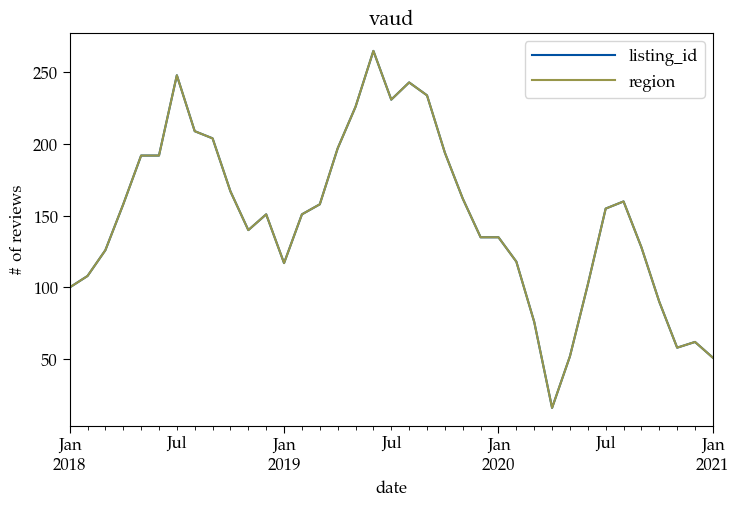

In [243]:
plot_timeperiod_reviews(start_date="2018-01", end_date='2021-01', n=40, data=reviews)

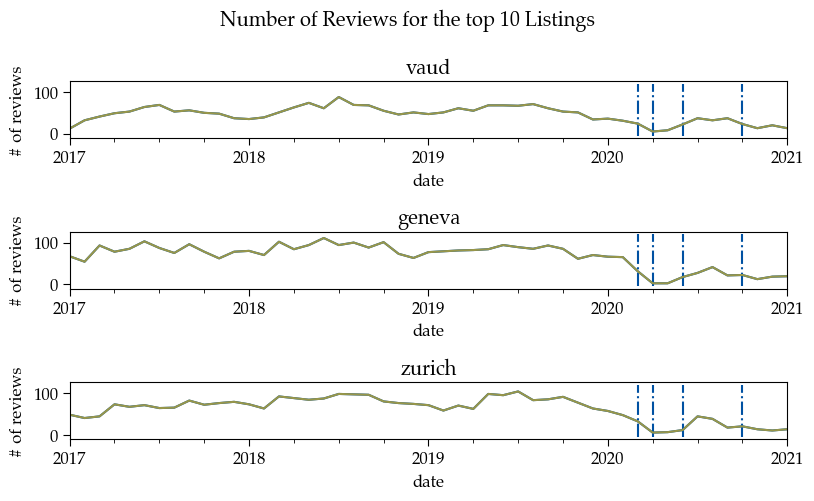

In [244]:
fig, axs = plt.subplots(3)
n_=10
fig.suptitle("Number of Reviews for the top %s Listings" % n_)
plot_timeperiod_reviews(start_date="2017-01", end_date='2021-01', n=n_, data=reviews, ax=axs[0])
plot_timeperiod_reviews(start_date="2017-01", end_date='2021-01', n=n_, data=reviews_gv, ax=axs[1])
plot_timeperiod_reviews(start_date="2017-01", end_date='2021-01', n=n_, data=reviews_zh, ax=axs[2])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
fig.tight_layout()

plt.savefig('reviews_top_10.png')

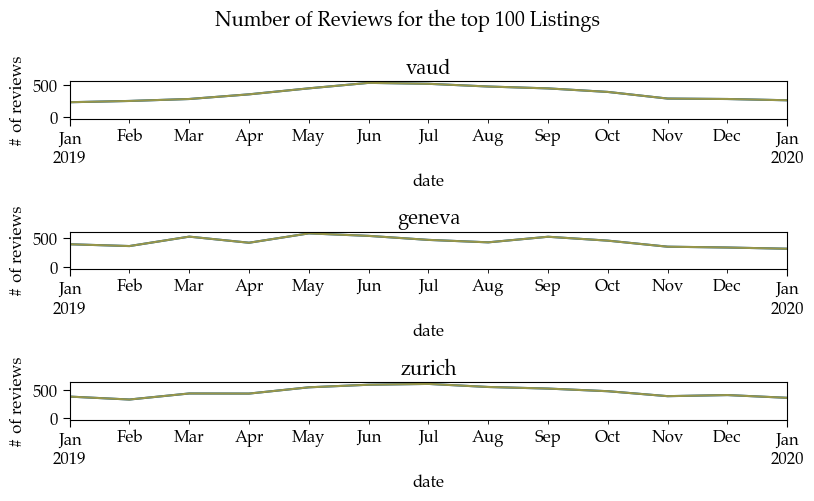

In [245]:
fig, axs = plt.subplots(3)
n_=100
fig.suptitle("Number of Reviews for the top %s Listings" % n_)
plot_timeperiod_reviews(start_date="2019-01", end_date='2020-01', n=n_, data=reviews, ax=axs[0])
plot_timeperiod_reviews(start_date="2019-01", end_date='2020-01', n=n_, data=reviews_gv, ax=axs[1])
plot_timeperiod_reviews(start_date="2019-01", end_date='2020-01', n=n_, data=reviews_zh, ax=axs[2])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
fig.tight_layout()

plt.savefig('reviews_top_10_yearly.png')

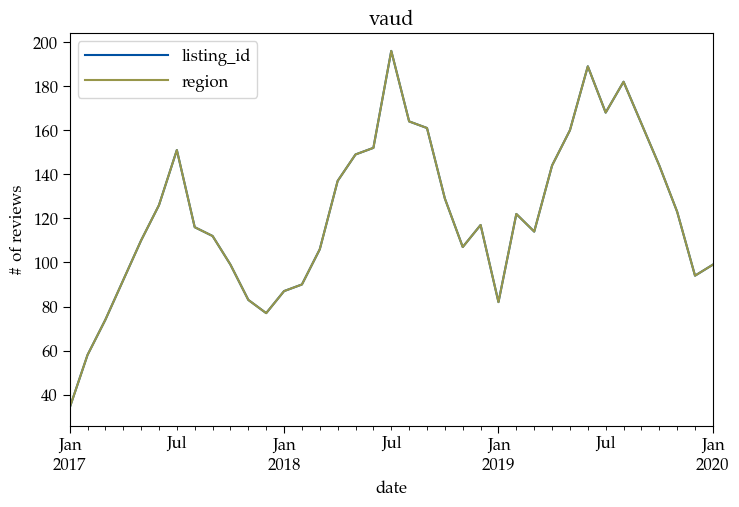

In [246]:
plot_timeperiod_reviews(start_date="2017-01", end_date='2020-01', n=30)

### Within the top 5 most reviewed listings, how do they temporally compare ?

In [247]:
from scipy.signal import savgol_filter

In [248]:
def plot_n_individual_reviews(start_date="2018-01", end_date="2021-01", n=2 , data=reviews, smoothed=True,ax = None):
    """plots the top n individual reviews between the given time period"""
    
    data= data.set_index('date')
    data['count'] = 1 #needed to count
    data_to_plot = data[data['listing_id'].isin(find_top_reviews(n,data))].groupby(['listing_id', pd.Grouper(freq='M')]).count()

    pivoted_data = data_to_plot.pivot_table(index='date', columns='listing_id', values='count', fill_value=0)
    title_ =  data['region'][0]
    
    if smoothed:
        for col in pivoted_data.columns.to_list():
            pivoted_data[col] = savgol_filter(pivoted_data[col],11,3)

        pivoted_data[pivoted_data < 0]=0
    
    pivoted_data.plot(title=title_, ylabel="# reviews", ax =ax)

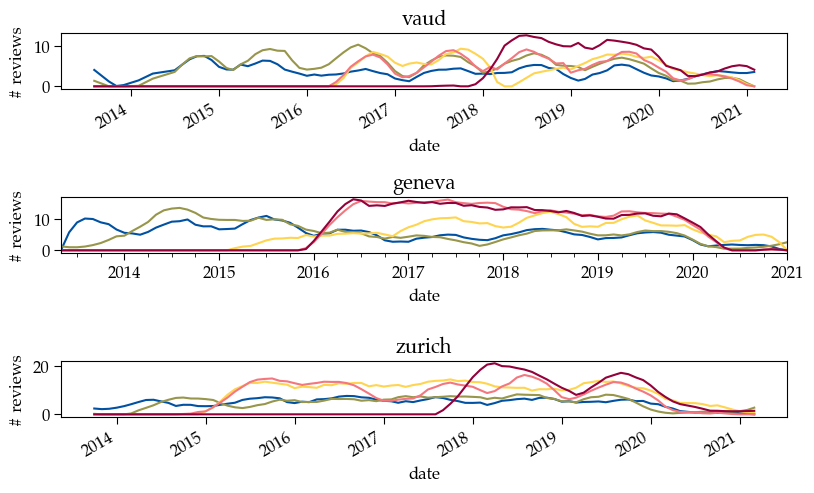

In [249]:
fig, axs = plt.subplots(3)

plot_n_individual_reviews(n=5,ax=axs[0])
plot_n_individual_reviews(n=5, data=reviews_gv, ax = axs[1])
plot_n_individual_reviews(n=5, data=reviews_zh, ax = axs[2])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
fig.tight_layout()

plt.savefig('top5_reviews_long.png')

In [ ]:
plot_n_individual_reviews(n=5, data=reviews_gv)

In [ ]:
plot_n_individual_reviews(n=5, data=reviews_zh)

In [ ]:
plot_n_individual_reviews(n=5, smoothed=False)

# Calendar

In [ ]:
def price_to_number(price):
    if isinstance(price, float):
        print(price)
    p = price[1:]
    if ',' in p:
        numb = float(p.replace(',',''))
    else:
        numb = float(p)
    return numb

In [ ]:
def format_calendar_data(calendar):
    calendar['date'] = pd.to_datetime(calendar['date'])
    calendar['adjusted_price'] = calendar['adjusted_price'].dropna().apply(price_to_number)
    calendar['price'] = calendar['price'].dropna().apply(price_to_number)
    calendar.set_index('date', inplace = True)
    return calendar

In [ ]:
# Vaud:
# recent dates:
PATH_VAUD = '../data/vaud/calendar_archives/'
calendar_recent = format_calendar_data(pd.read_csv(PATH_VAUD+'calendar_04_02_2021.csv'))

# second wave:
cal_10_12_2020 = format_calendar_data(pd.read_csv(PATH_VAUD+'calendar_10_12_2020.csv'))

# first wave:
cal_19_05_2020 = format_calendar_data(pd.read_csv(PATH_VAUD+'calendar_19_05_2020.csv'))

# before pandemic:
cal_31_01_2020 = format_calendar_data( pd.read_csv(PATH_VAUD+'calendar_31_01_2020.csv'))

# Zurich:
# recent dates:
PATH_ZH = '../data/zurich/calendar_archives/'
calendar_recent_zh = format_calendar_data(pd.read_csv(PATH_ZH+'calendar_04_02_2021.csv'))

# second wave:
cal_10_12_2020_zh = format_calendar_data(pd.read_csv(PATH_ZH+'calendar_10_12_2020.csv'))

# first wave:
cal_29_10_2020_zh = format_calendar_data(pd.read_csv(PATH_ZH+'calendar_29_10_2020.csv'))

# before pandemic:
cal_29_11_2020_zh = format_calendar_data( pd.read_csv(PATH_ZH+'calendar_29_11_2020.csv'))

# Geneva: 
# recent dates:
PATH_GV = '../data/geneva/calendar_archives/'
calendar_recent_gv = format_calendar_data(pd.read_csv(PATH_GV+'calendar_04_02_2021.csv'))

# second wave:
cal_10_12_2020_gv = format_calendar_data(pd.read_csv(PATH_GV+'calendar_10_12_2020.csv'))

# first wave:
cal_19_05_2020_gv = format_calendar_data(pd.read_csv(PATH_GV+'calendar_19_05_2020.csv'))

# before pandemic:
calendar_08_01_2021_gv = format_calendar_data( pd.read_csv(PATH_GV+'calendar_08_01_2021.csv'))

In [ ]:
cal_29_11_2020_zh

### Mean price:

In [ ]:
mean_price = calendar_recent.groupby('listing_id').mean().drop(
    ['minimum_nights', 'maximum_nights'], axis=1)
mean_price_zh = calendar_recent_zh.groupby('listing_id').mean().drop(
    ['minimum_nights', 'maximum_nights'], axis=1)
mean_price_gv = calendar_recent_gv.groupby('listing_id').mean().drop(
    ['minimum_nights', 'maximum_nights'], axis=1)
mean_price.head(4)

In [ ]:
from matplotlib.ticker import PercentFormatter


fig, ax = plt.subplots()
sns.distplot(mean_price['price'],
             ax=ax,
             hist_kws={'alpha': 0.1},
             label='price')
sns.distplot(mean_price['adjusted_price'],
             ax=ax,
             hist_kws={'alpha': 0.1},
             label='adjusted price')

plt.gca().yaxis.set_major_formatter(PercentFormatter(0.01))
ax.set_xlim([0, 1000])
plt.title('Distribution of the average price and adjusted price for each listing')
plt.legend()

In [ ]:
from matplotlib.ticker import PercentFormatter


fig, ax = plt.subplots()
sns.distplot(mean_price['price'],
             ax=ax,
             hist_kws={'alpha': 0.1},
             label='price Vaud')
sns.distplot(mean_price_zh['price'],
             ax=ax,
             hist_kws={'alpha': 0.1},
             label='price Zurich')
sns.distplot(mean_price_gv['price'],
             ax=ax,
             hist_kws={'alpha': 0.1},
             label='price Geneva')
plt.gca().yaxis.set_major_formatter(PercentFormatter(0.01))
ax.set_xlim([0, 1000])
ax.set_xlabel('Average price per night [$]')
plt.title('Distribution of the average price for each listing in three locations')
plt.legend()

In [ ]:
labels = pd.concat([
    pd.Series(np.ones(len(mean_price['price']))),
    pd.Series(np.zeros(len(mean_price['adjusted_price'])))
])
long = pd.DataFrame(
    pd.concat([mean_price['price'], mean_price['adjusted_price']]))
long['labels'] = labels.values
long.columns = ['mean price', 'labels']

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(x='labels',
            data=long,
            hue='labels',
            y='mean price',
            palette=["m", "g"])
ax.set_ylim([0, 400])
plt.title('Boxplots of normal (left) and adjusted (right) price')

### Price categories: 

In [ ]:
max_ = math.floor(np.max(mean_price['price'].values))
min_ = math.floor(np.min(mean_price['price'].values))

labels = ["{0} - {1}".format(i, i + 100) for i in range(0, max_, 101)]

mean_price['category'] = pd.cut(mean_price['price'].values,
       range(0, max_, 100),
       right=False,
       labels=labels)

mean_price_zh['category'] = pd.cut(mean_price_zh['price'].values,
       range(0, max_, 100),
       right=False,
       labels=labels)

mean_price_gv['category'] = pd.cut(mean_price_gv['price'].values,
       range(0, max_, 100),
       right=False,
       labels=labels)
mean_price

In [ ]:
def label_function(val):
    return f'{val / 100 * len(mean_price):.0f}\n{val:.0f}%'

fig, ax = plt.subplots(1,3, figsize=(15, 5))

biggest_cat = mean_price.groupby('category').size()
biggest_cat[biggest_cat > 80].plot(kind='pie',
                                   autopct=label_function,
                                   textprops={'fontsize': 12}, ax = ax[0])
ax[0].set_title('Vaud')
ax[0].set_ylabel('')

biggest_cat_ZH = mean_price_zh.groupby('category').size()
biggest_cat_ZH[biggest_cat_ZH > 80].plot(kind='pie',
                                   autopct=label_function,
                                   textprops={'fontsize': 12}, ax = ax[1])
ax[1].set_title('Zurich')
ax[1].set_ylabel('')


biggest_cat_GV = mean_price_gv.groupby('category').size()
biggest_cat_GV[biggest_cat_GV > 80].plot(kind='pie',
                                   autopct=label_function,
                                   textprops={'fontsize': 12}, ax = ax[2])
ax[2].set_title('Geneva')
ax[2].set_ylabel('')

plt.suptitle('Percentage of listings per price [$/night] category')

### Price predictions over time:

In [ ]:
max_ = math.floor(np.max(calendar_recent['price'].values))
min_ = math.floor(np.min(calendar_recent['price'].values))

labels = ["{0} - {1}".format(i, i + 100) for i in range(0, max_, 101)]

calendar_recent['category'] = pd.cut(calendar_recent['price'].values,
       range(0, max_, 100),
       right=False,
       labels=labels)

calendar_recent_zh['category'] = pd.cut(calendar_recent_zh['price'].values,
       range(0, max_, 100),
       right=False,
       labels=labels)

calendar_recent_gv['category'] = pd.cut(calendar_recent_gv['price'].values,
       range(0, max_, 100),
       right=False,
       labels=labels)

# take first price category:
first_cat = calendar_recent[calendar_recent['category']=='0 - 100']
second_cat = calendar_recent[calendar_recent['category']=='101 - 201']
third_cat = calendar_recent[calendar_recent['category']=='202 - 302']
fourth_cat = calendar_recent[calendar_recent['category']=='303 - 403']

In [ ]:
# holidays_vaud: 
holidays_vaud = pd.read_csv('../data/vaud/holidays_vaud.csv')
holidays_vaud['Date'] = pd.to_datetime(holidays_vaud['Date'])

holidays_zurich = pd.read_csv('../data/zurich/holidays_zurich.csv')
holidays_zurich['Date'] = pd.to_datetime(holidays_zurich['Date'])

holidays_geneva = pd.read_csv('../data/geneva/holidays_geneva.csv')
holidays_geneva['Date'] = pd.to_datetime(holidays_geneva['Date'])

#### Average price:

In [ ]:
def avg_ts(df, listings_):
    # average time-series over those listings:
    t = np.zeros((N, len(x)))
    
    for i in range(N):
        if len(df[df['listing_id'] == listings_[i]].price.index)>=365:
            index = df[df['listing_id'] == listings_[i]].price.index[:365]
            break
    for i in range(N):
        if len(df[df['listing_id'] == listings_[i]])>=365:
            t[i] = df[df['listing_id'] == listings_[i]].price[index]
    
    df = pd.DataFrame(t)
    df = df[(df.T != 0).any()]
    time_series = df.T
    time_series.set_index(index, inplace = True)
    time_series = time_series.dropna()
    # Average price over period:
    mean_ = time_series.mean(axis=1)
    return mean_

In [ ]:
import random


def average_time_series(cal_31_01_2020, cal_19_05_2020, cal_10_12_2020,
                        calendar_recent, holidays, place):

    # take first price category:
    first_cat = calendar_recent[calendar_recent['category'] == '0 - 100']
    second_cat = calendar_recent[calendar_recent['category'] == '101 - 201']
    third_cat = calendar_recent[calendar_recent['category'] == '202 - 302']
    fourth_cat = calendar_recent[calendar_recent['category'] == '303 - 403']

    # sample 100 listings from that category:
    N = 100
    random.seed(1)
    list_1 = [random.choices(first_cat['listing_id'])[0] for i in range(N)]
    list_2 = [random.choices(second_cat['listing_id'])[0] for i in range(N)]
    list_3 = [random.choices(third_cat['listing_id'])[0] for i in range(N)]
    list_4 = [random.choices(fourth_cat['listing_id'])[0] for i in range(N)]

    # rolling mean to smooth time-series:
    window = 10
    mean_31_01_2020_first = avg_ts(cal_31_01_2020,
                                   list_1).iloc[:].rolling(window).mean()
    mean_19_05_2020_first = avg_ts(cal_19_05_2020,
                                   list_1).iloc[:].rolling(window).mean()
    mean_10_12_2020_first = avg_ts(cal_10_12_2020,
                                   list_1).iloc[:].rolling(window).mean()
    mean_04_02_2021_first = avg_ts(calendar_recent,
                                   list_1).iloc[:].rolling(window).mean()

    mean_31_01_2020_scn = avg_ts(cal_31_01_2020,
                                 list_2).iloc[:].rolling(window).mean()
    mean_19_05_2020_scn = avg_ts(cal_19_05_2020,
                                 list_2).iloc[:].rolling(window).mean()
    mean_10_12_2020_scn = avg_ts(cal_10_12_2020,
                                 list_2).iloc[:].rolling(window).mean()
    mean_04_02_2021_scn = avg_ts(calendar_recent,
                                 list_2).iloc[:].rolling(window).mean()

    mean_31_01_2020_thrd = avg_ts(cal_31_01_2020,
                                  list_3).iloc[:].rolling(window).mean()
    mean_19_05_2020_thrd = avg_ts(cal_19_05_2020,
                                  list_3).iloc[:].rolling(window).mean()
    mean_10_12_2020_thrd = avg_ts(cal_10_12_2020,
                                  list_3).iloc[:].rolling(window).mean()
    mean_04_02_2021_thrd = avg_ts(calendar_recent,
                                  list_3).iloc[:].rolling(window).mean()

    mean_31_01_2020_4th = avg_ts(cal_31_01_2020,
                                 list_4).iloc[:].rolling(window).mean()
    mean_19_05_2020_4th = avg_ts(cal_19_05_2020,
                                 list_4).iloc[:].rolling(window).mean()
    mean_10_12_2020_4th = avg_ts(cal_10_12_2020,
                                 list_4).iloc[:].rolling(window).mean()
    mean_04_02_2021_4th = avg_ts(calendar_recent,
                                 list_4).iloc[:].rolling(window).mean()

    # Plot:
    fig, axs = plt.subplots(4, 1, figsize=(15, 18))

    # 1st cat:
    axs[0].plot(mean_31_01_2020_first, label='Pre-pandemic')
    axs[0].plot(mean_19_05_2020_first, label='First wave')
    axs[0].plot(mean_10_12_2020_first, label='Second wave')
    axs[0].plot(mean_04_02_2021_first, label='Second wave')
    axs[0].set_title('Average price predictions for listings [0-100]$/night:')
    axs[0].legend()

    # 2nd cat:
    axs[1].plot(mean_31_01_2020_scn, label='Pre-pandemic')
    axs[1].plot(mean_19_05_2020_scn, label='First wave')
    axs[1].plot(mean_10_12_2020_scn, label='Second wave')
    axs[1].plot(mean_04_02_2021_scn, label='Second wave')
    axs[1].set_title(
        'Average price predictions for listings [100-200]$/night:')
    axs[1].legend()

    # 3rd cat:
    axs[2].plot(mean_31_01_2020_thrd, label='Pre-pandemic')
    axs[2].plot(mean_19_05_2020_thrd, label='First wave')
    axs[2].plot(mean_10_12_2020_thrd, label='Second wave')
    axs[2].plot(mean_04_02_2021_thrd, label='Second wave')
    axs[2].set_title(
        'Average price predictions for listings [200-300]$/night:')
    axs[2].legend()

    # 4th cat:
    axs[3].plot(mean_31_01_2020_4th, label='Pre-pandemic')
    axs[3].plot(mean_19_05_2020_4th, label='First wave')
    axs[3].plot(mean_10_12_2020_4th, label='Second wave')
    axs[3].plot(mean_04_02_2021_4th, label='Second wave')
    axs[3].set_title(
        'Average price predictions for listings [300-400]$/night:')
    axs[3].legend()

    for i in range(len(holidays)):
        axs[0].axvline(holidays['Date'].iloc[i], linestyle='dotted', color='grey')
        axs[1].axvline(holidays['Date'].iloc[i], linestyle='dotted', color='grey')
        axs[2].axvline(holidays['Date'].iloc[i], linestyle='dotted', color='grey')
        axs[3].axvline(holidays['Date'].iloc[i], linestyle='dotted', color='grey')
    pandemic = [
        pd.to_datetime('13-03-2020', dayfirst = True),
        pd.to_datetime('27-04-2020', dayfirst = True),
        pd.to_datetime('25-06-2020', dayfirst = True),
        pd.to_datetime('22-10-2020', dayfirst = True)
    ]
    for dates in pandemic:
        axs[0].axvline(dates, linestyle='dotted', color='red')
        axs[1].axvline(dates, linestyle='dotted', color='red')
        axs[2].axvline(dates, linestyle='dotted', color='red')
        axs[3].axvline(dates, linestyle='dotted', color='red')
    plt.legend()
    plt.suptitle(f'Average price for different price categories ({place})')

In [ ]:
average_time_series(cal_31_01_2020, cal_19_05_2020, cal_10_12_2020,
                    calendar_recent, holidays_vaud, 'Vaud')

In [ ]:
average_time_series(cal_29_10_2020_zh, cal_29_11_2020_zh, cal_10_12_2020_zh,
                    calendar_recent_zh, holidays_zurich, 'Zurich')

In [ ]:
average_time_series(calendar_08_01_2021_gv, cal_19_05_2020_gv, cal_10_12_2020_gv,
                    calendar_recent_gv, holidays_geneva, 'Geneva')

#### One listing:

In [ ]:
list_id = 7381
one_list = calendar_recent[calendar_recent['listing_id'] == list_id]
one_list_08 = cal_08_01_2021[cal_08_01_2021['listing_id'] == list_id]
one_list_10 = cal_10_12_2020[cal_10_12_2020['listing_id'] == list_id]
one_list_19 = cal_19_05_2020[cal_19_05_2020['listing_id'] == list_id]
one_list_31 = cal_31_01_2020[cal_31_01_2020['listing_id'] == list_id]

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (15,5))

# 2020:
axs[0].plot(one_list_10['price']['2020'], label='Pre-pandemic: 10.12.2020')
axs[0].plot(one_list_19['price']['2020'], label='First wave: 19.05.2020')
axs[0].plot(one_list_31['price']['2020'], label='Beginning second wave: 31.01.2020')
axs[0].set_title('Price predictions in 2020 for one listing:')

# 2021:
axs[1].plot(one_list['price'], label='Second wave: 4.02.2021')
axs[1].plot(one_list_08['price']['2021'], label='Second wave: 08.01.2021')
axs[1].plot(one_list_19['price']['2021'], label='First wave: 19.05.2020')
axs[1].set_title('Price predictions in 2021 for one listing:')